In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [75]:
import pandas as pd
import numpy as np
from importlib import reload
from tqdm import tqdm_notebook as tqdm
import time

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot
%matplotlib inline

In [3]:
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

257484 studies loaded!


In [232]:
ss.add_dimensions(['baseline_measurements'])
ss.add_dimensions(['result_groups'])
ss.add_dimensions(['eligibilities'])
ss.refresh_dim_data()

Successfuly added these 1 dimensions: ['baseline_measurements']
Failed to add these 0 dimensions: []
Successfuly added these 1 dimensions: ['result_groups']
Failed to add these 0 dimensions: []
Successfuly added these 1 dimensions: ['eligibilities']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 515 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension eligibilities
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index


In [233]:
num_all = ss.studies.shape[0]
num_all

257484

In [234]:
bm = ss.dimensions['baseline_measurements'].data
rg = ss.dimensions['result_groups'].data
el = ss.dimensions['eligibilities'].data

## Where are all the places we can find gender information in bm?

In [24]:
bm.head()

id ctgov_group_code    classification  \
nct_id      result_group_id                                               
NCT00000125 3090367          3368138               B3             Other   
            3090367          3368141               B3             White   
            3090367          3368144               B3          Hispanic   
            3090367          3368147               B3  African American   
            3090367          3368150               B3             Asian   

                            category                       title description  \
nct_id      result_group_id                                                    
NCT00000125 3090367                   Race/Ethnicity, Customized               
            3090367                   Race/Ethnicity, Customized               
            3090367                   Race/Ethnicity, Customized               
            3090367                   Race/Ethnicity, Customized               
            3090367                   Race/Ethnicity, Customized               

                                    units param_type param_value  \
nct_id      result_group_id                                        
NCT00000125 3090367          participants     Number          14   
            3090367          participants     Number        1137   
            3090367          participants     Number          59   
            3090367          participants     Number         408   
            3090367          participants     Number          14   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00000125 3090367                     14.0                             None   
            3090367                   1137.0                             None   
            3090367                     59.0                             None   
            3090367                    408.0                             None   
            3090367                     14.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00000125 3090367                           NaN                     NaN   
            3090367                           NaN                     NaN   
            3090367                           NaN                     NaN   
            3090367                           NaN                     NaN   
            3090367                           NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  
nct_id      result_group_id                                            
NCT00000125 3090367                             NaN                    
            3090367                             NaN                    
            3090367                             NaN                    
            3090367                             NaN                    
            3090367                             NaN

In [80]:
bm.shape

(1084151, 16)

In [83]:
bm_all = bm.index.get_level_values(0).unique().shape[0]
bm_all

38198

<hr>

##### searching in the "classification" field

In [84]:
possible_classes = [x for x in bm['classification'].unique() if 'male' in x.lower()]

In [85]:
dfc = bm[bm['classification'].isin(possible_classes)]
dfc.shape, dfc.index.get_level_values(0).unique().shape[0]/bm_all

((5445, 16), 0.02167652756688832)

In [88]:
dfc['title'].unique()[:10]

array(['Gender', 'Sex/Gender, Customized',
       'Family History of Coronary Artery Disease', 'Visit type', 'Age',
       'History of Vomiting with Pregnancy',
       'Clayton Sexual Functioning Questionnaire (CSFQ)',
       'Gender at Beginning of Long term Follow-up Period',
       'Gender, by Disease Type', 'Donor gender'], dtype=object)

In [94]:
dfc.groupby('classification').size().sort_values(ascending=False)[:10]

classification
Female                                 1866
Male                                   1848
Female of Childbearing Potential        113
Females                                  57
Males                                    40
N/A (Subject is Male)                    30
Female of childbearing potential         30
Females of Child-bearing Potential       26
Sterilized Females                       26
Males (Excluded from this analysis)      26
dtype: int64

##### Use Female, Male and their plurals

In [95]:
used_classes = ['female', 'male', 'females', 'males']

In [99]:
used_dfc = dfc[dfc['classification'].apply(lambda x: x.lower()).isin(used_classes)]
res_studies_dfc = used_dfc.index.get_level_values(0).unique().shape[0]
res_studies_dfc

681

In [161]:
used_dfc['classification'].unique()

array(['Male', 'Female', 'male', 'Males', 'Females', 'female', 'FEMALE',
       'MALE', 'females', 'males'], dtype=object)

In [110]:
pct_classes = res_studies_dfc / bm_all
pct_classes

0.017828158542332058

##### conclusion: using the "classification" field for the gender infor gets us just under 2% of the 38k studies with baseline metrics, where else can we get gender information?

<hr>

##### searching in the "category" field

In [101]:
bm.groupby('category').size().sort_values(ascending=False)

category
                                        488158
Male                                    107680
Female                                  107662
Unknown or Not Reported                  41277
>=65 years                               35213
                                         ...  
Non-dominant Hand                            1
Non-cystic fibrosis related diabetes         1
> 200,000 copies/mL                          1
> 21 years                                   1
Follicular Lymphoma, Grade 1                 1
Length: 7662, dtype: int64

In [102]:
possible_class_cat = [x for x in bm['category'].unique() if 'male' in x.lower()]
possible_class_cat

['Male',
 'Female',
 'not applicable (male)',
 'Female-Female',
 'Male-Male',
 'Female-Male',
 'Male-Female',
 'Male patients',
 'High (>=102 cm for male and >=88 cm for female)',
 'Low (<102 cm for male and <88 cm for female)',
 'male',
 'female',
 'Male Donor, Male Recipient',
 'Male Donor, Female Recipient',
 'Female Donor, Male Recipient',
 'Female Donor, Female Recipient',
 'MALE',
 'FEMALE',
 'Transfemale',
 'Females',
 'Males',
 'Sex (Female Only)',
 'Female donor / Female Recipient',
 'Female donor / Male Recipient',
 'Male donor / Female Recipient',
 'Male donor / Male Recipient',
 'Female ≥4',
 'Female <4',
 'Male ≥8',
 'Male <8',
 'Female of Childbearing Potential',
 'Female of childbearing potential',
 'Not applicable (male participants)',
 'Female - shirt collar >=16 in/41 cm',
 'Female - shirt collar <16 in/41 cm',
 'Male - shirt collar >= 17 in/43 cm',
 'Male - shirt collar <17 in/43 cm',
 'Not Applicable (Male)',
 'Tubal and male factors',
 'Male factor',
 'Not applicab

In [103]:
# aside: what are those with both genders listed, such as 'Female-Male'?
cur_list = ['Female-Female',
'Male-Male',
'Female-Male',
'Male-Female',]

cur_df = bm[bm['category'].isin(cur_list)]
cur_df

# ah donor to recipients

id ctgov_group_code classification  \
nct_id      result_group_id                                            
NCT00448357 2950959          3218413               B1                  
            2950959          3218414               B1                  
            2950959          3218415               B1                  
            2950959          3218416               B1                  

                                  category                title description  \
nct_id      result_group_id                                                   
NCT00448357 2950959          Female-Female  Donor-recipient sex               
            2950959              Male-Male  Donor-recipient sex               
            2950959            Female-Male  Donor-recipient sex               
            2950959            Male-Female  Donor-recipient sex               

                                    units             param_type param_value  \
nct_id      result_group_id                                                    
NCT00448357 2950959          Participants  Count of Participants          14   
            2950959          Participants  Count of Participants          22   
            2950959          Participants  Count of Participants          12   
            2950959          Participants  Count of Participants           6   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00448357 2950959                     14.0                             None   
            2950959                     22.0                             None   
            2950959                     12.0                             None   
            2950959                      6.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00448357 2950959                           NaN                     NaN   
            2950959                           NaN                     NaN   
            2950959                           NaN                     NaN   
            2950959                           NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  
nct_id      result_group_id                                            
NCT00448357 2950959                             NaN                    
            2950959                             NaN                    
            2950959                             NaN                    
            2950959                             NaN

In [104]:
dfcat = bm[bm['category'].isin(possible_class_cat)]
dfcat.shape

(215608, 16)

In [106]:
dfcat.groupby('category').size().sort_values(ascending=False)[:6]

category
Male                                107680
Female                              107662
FEMALE                                  68
MALE                                    68
Female of childbearing potential        18
Not Applicable (Male)                    5
dtype: int64

Seems like if we just use "Male, Female" in any case, we will capture the vast majority of cases in this category

In [112]:
used_cats = ['male', 'female']
used_dfcat = bm[bm['category'].apply(lambda x: x.lower()).isin(used_cats)]

In [160]:
used_dfcat['category'].unique()

array(['Male', 'Female', 'male', 'female', 'MALE', 'FEMALE'], dtype=object)

In [113]:
pct_cats = np.unique(used_dfcat.index.get_level_values(0)).shape[0] / bm_all
pct_cats

0.9784281899575894

#### This seems a majority of our studies, is there overlap between identifying gender using classification vs using category?

Let's analyse their intersections

In [181]:
used_dfc['classification'].unique()

array(['Male', 'Female', 'male', 'Males', 'Females', 'female', 'FEMALE',
       'MALE', 'females', 'males'], dtype=object)

In [182]:
used_dfc.groupby('category').size().sort_values(ascending=False)

category
                           3849
Male                          7
Female                        4
Between 18 and 65 years       4
>=65 years                    4
<=18 years                    4
Transfemale                   3
dtype: int64

Most of the valid classifications have null as category, what about the others?

In [185]:
cur_to_investigate = used_dfc.groupby('category').size().sort_values(ascending=False)[3:].index
used_dfc[used_dfc['category'].isin(cur_to_investigate)]

id ctgov_group_code classification  \
nct_id      result_group_id                                            
NCT01781806 2384509          2641670               B3           Male   
            2384510          2641671               B2           Male   
            2384511          2641672               B1           Male   
NCT02844998 2115438          2314833               B4           Male   
            2115438          2314837               B4           Male   
            2115438          2314841               B4           Male   
            2115439          2314834               B3           Male   
            2115439          2314838               B3           Male   
            2115439          2314842               B3           Male   
            2115440          2314835               B2           Male   
            2115440          2314839               B2           Male   
            2115440          2314843               B2           Male   
            2115441          2314836               B1           Male   
            2115441          2314840               B1           Male   
            2115441          2314844               B1           Male   

                                            category                   title  \
nct_id      result_group_id                                                    
NCT01781806 2384509                      Transfemale  Sex/Gender, Customized   
            2384510                      Transfemale  Sex/Gender, Customized   
            2384511                      Transfemale  Sex/Gender, Customized   
NCT02844998 2115438                       >=65 years                     Age   
            2115438          Between 18 and 65 years                     Age   
            2115438                       <=18 years                     Age   
            2115439                       >=65 years                     Age   
            2115439          Between 18 and 65 years                     Age   
            2115439                       <=18 years                     Age   
            2115440                       >=65 years                     Age   
            2115440          Between 18 and 65 years                     Age   
            2115440                       <=18 years                     Age   
            2115441                       >=65 years                     Age   
            2115441          Between 18 and 65 years                     Age   
            2115441                       <=18 years                     Age   

                            description         units             param_type  \
nct_id      result_group_id                                                    
NCT01781806 2384509                      Participants  Count of Participants   
            2384510                      Participants  Count of Participants   
            2384511                      Participants  Count of Participants   
NCT02844998 2115438                      Participants  Count of Participants   
            2115438                      Participants  Count of Participants   
            2115438                      Participants  Count of Participants   
            2115439                      Participants  Count of Participants   
            2115439                      Participants  Count of Participants   
            2115439                      Participants  Count of Participants   
            2115440                      Participants  Count of Participants   
            2115440                      Participants  Count of Participants   
            2115440                      Participants  Count of Participants   
            2115441                      Participants  Count of Participants   
            2115441                      Participants  Count of Participants   
            2115441                      Participants  Count of Participants   

                            param_value  param_value_num dispersion_type  \
nct_id     

### looks like this is only 2 studies, one is on transgender and the other is male only so we can exclude from our balance analysis

In [187]:
used_dfcat['category'].unique()

array(['Male', 'Female', 'male', 'female', 'MALE', 'FEMALE'], dtype=object)

In [188]:
used_dfcat.groupby('classification').size().sort_values(ascending=False)

classification
                           214362
Part 2                         60
Sex                            58
Gender                         46
Part A                         34
                            ...  
Full analysis set (FAS)         2
GIST                            2
BiRD Phase                      2
Baseline Period Sex             2
Neuro-typical                   2
Length: 147, dtype: int64

In [189]:
used_dfcat.groupby('classification').size().sort_values(ascending=False) / used_dfcat.shape[0]

classification
                           0.994793
Part 2                     0.000278
Sex                        0.000269
Gender                     0.000213
Part A                     0.000158
                             ...   
Full analysis set (FAS)    0.000009
GIST                       0.000009
BiRD Phase                 0.000009
Baseline Period Sex        0.000009
Neuro-typical              0.000009
Length: 147, dtype: float64

##### This one looks like there is more crosses, but most of it still has '' - for simplicity let's just take the null studies

In [191]:
used_dfc_final = used_dfc[used_dfc['category'] == '']
used_dfc_final.shape

(3849, 16)

In [192]:
used_dfcat_final = used_dfcat[used_dfcat['classification'] == '']
used_dfcat_final.shape

(214362, 16)

### what about the overlap between the two sets?

In [197]:
i1 = used_dfc_final.index.get_level_values(0).unique()
i2 = used_dfcat_final.index.get_level_values(0).unique()

In [198]:
len(i1), len(i2), bm_all

(680, 37278, 38198)

In [199]:
len_overlap = len([x for x in i1 if x in i2])
len_overlap

42

In [200]:
overlap_nctids = [x for x in i1 if x in i2]
overlap_nctids[:5]

['NCT00095303', 'NCT00247611', 'NCT00284089', 'NCT00287469', 'NCT00340834']

Looks like 44 studies can be identified both ways

In [201]:
(len(i1) + len(i2) - len_overlap) / bm_all

0.9926174145243206

##### we can cover 99.3% of our studies with baseline measurements just using these 2 ways of identifying gender - this is good enough

In [230]:
used_dfc_final.index[2][0], used_dfcat_final.index[0][0]

('NCT00002525', 'NCT00000125')

In [231]:
used_dfc_final.loc['NCT00002525']

,id,ctgov_group_code,classification,category,title,description,units,param_type,param_value,param_value_num,dispersion_type,dispersion_value,dispersion_value_num,dispersion_lower_limit,dispersion_upper_limit,explanation_of_na
result_group_id,,,,,,,,,,,,,,,,
3077994,3350816,B3,Male,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,195,195.0,,None,NaN,NaN,NaN,
3077994,3350819,B3,Female,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,118,118.0,,None,NaN,NaN,NaN,
3077995,3350817,B2,Male,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,96,96.0,,None,NaN,NaN,NaN,
3077995,3350820,B2,Female,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,61,61.0,,None,NaN,NaN,NaN,
3077996,3350818,B1,Male,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,99,99.0,,None,NaN,NaN,NaN,
3077996,3350821,B1,Female,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,57,57.0,,None,NaN,NaN,NaN,


In [236]:
rg.loc['NCT00002525']

,id,ctgov_group_code,result_type,title,description
nct_id,,,,,
NCT00002525,3077994,B3,Baseline,Total,Total of all reporting groups
NCT00002525,3077995,B2,Baseline,No Perioperative 5-FU,Patients receive no perioperative fluorouracil...
NCT00002525,3077996,B1,Baseline,Perioperative 5-FU,"Within 24 hours of the colon resection, patien..."
NCT00002525,3077997,P2,Participant Flow,No Perioperative 5-FU,Patients receive no perioperative fluorouracil...
NCT00002525,3077998,P1,Participant Flow,Perioperative 5-FU,"Within 24 hours of the colon resection, patien..."
NCT00002525,3077999,O2,Outcome,No Perioperative 5-FU,Patients receive no perioperative fluorouracil...
NCT00002525,3078000,O1,Outcome,Perioperative 5-FU,"Within 24 hours of the colon resection, patien..."
NCT00002525,3078001,O2,Outcome,No Perioperative 5-FU,Patients receive no perioperative fluorouracil...
NCT00002525,3078002,O1,Outcome,Perioperative 5-FU,"Within 24 hours of the colon resection, patien..."


### let's build the gender information df using these 2 methods

In [202]:
used_df_both = pd.concat([used_dfc_final, used_dfcat_final])
used_df_both.shape

(218211, 16)

In [207]:
used_df_both['classification'].unique()

array(['Male', 'Female', 'male', 'Males', 'Females', 'female', 'FEMALE',
       'MALE', 'females', 'males', ''], dtype=object)

In [209]:
used_classes

['female', 'male', 'females', 'males']

In [208]:
used_df_both['category'].unique()

array(['', 'Male', 'Female', 'male', 'female', 'MALE', 'FEMALE'],
      dtype=object)

In [210]:
used_cats

['male', 'female']

In [215]:
def is_male(row):
    cur_class = row['classification']
    cur_cat = row['category']
    if 'female' in cur_class.lower() or 'female' in cur_cat.lower():
        return False
    return True

In [217]:
used_df_both['is_male'] = used_df_both.apply(is_male, axis=1)

In [218]:
used_df_both.head()

id ctgov_group_code classification category  \
nct_id      result_group_id                                                     
NCT00001213 3090179          3367810               B1           Male            
            3090179          3367811               B1         Female            
NCT00002525 3077994          3350816               B3           Male            
            3077994          3350819               B3         Female            
            3077995          3350817               B2           Male            

                              title  \
nct_id      result_group_id           
NCT00001213 3090179          Gender   
            3090179          Gender   
NCT00002525 3077994          Gender   
            3077994          Gender   
            3077995          Gender   

                                                                   description  \
nct_id      result_group_id                                                      
NCT00001213 3090179          Gender was captured for 326 out of 328 partici...   
            3090179          Gender was captured for 326 out of 328 partici...   
NCT00002525 3077994          1 patient on "No perioperative 5-FU arm" had m...   
            3077994          1 patient on "No perioperative 5-FU arm" had m...   
            3077995          1 patient on "No perioperative 5-FU arm" had m...   

                                    units param_type param_value  \
nct_id      result_group_id                                        
NCT00001213 3090179          participants     Number         173   
            3090179          participants     Number         153   
NCT00002525 3077994          participants     Number         195   
            3077994          participants     Number         118   
            3077995          participants     Number          96   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00001213 3090179                    173.0                             None   
            3090179                    153.0                             None   
NCT00002525 3077994                    195.0                             None   
            3077994                    118.0                             None   
            3077995                     96.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00001213 3090179                           NaN                     NaN   
            3090179                           NaN                     NaN   
NCT00002525 3077994                           NaN                     NaN   
            3077994                           NaN                     NaN   
            3077995                           NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  is_male  
nct_id      result_group_id                                                     
NCT00001213 3090179                             NaN                       True  
            3090179                             NaN                      False  
NCT00002525 3077994                             NaN                       True  
            3077994                             NaN                      False  
            3077995                             NaN                       True

### Q1: what is the distribution of studies by gender eligibility?

In [237]:
# is the index on eligibility unique?
el.index.shape, el.index.unique().shape

# Yes

((257484,), (257484,))

In [238]:
el.groupby('gender').size()/el.shape[0]

gender
          0.000050
All       0.850628
Female    0.097707
Male      0.051615
dtype: float64

### Q2: if the eligibility is only by gender, do the studies accurately recruit that gender?

In [239]:
el_female = el[el['gender'] == 'Female']
el_female.shape

(25158, 10)

In [241]:
df_female = el_female[[]].join(used_df_both)
df_female.head()

id ctgov_group_code classification category  \
nct_id      result_group_id                                                     
NCT00004888 3085562          3362332               B3         Female            
            3085563          3362333               B2         Female            
            3085564          3362334               B1         Female            
NCT00062751 3082311          3357259               B6         Female            
            3082312          3357260               B5         Female            

                                              title  \
nct_id      result_group_id                           
NCT00004888 3085562          Sex/Gender, Customized   
            3085563          Sex/Gender, Customized   
            3085564          Sex/Gender, Customized   
NCT00062751 3082311          Sex/Gender, Customized   
            3082312          Sex/Gender, Customized   

                                              description         units  \
nct_id      result_group_id                                               
NCT00004888 3085562          All participants are female.  participants   
            3085563          All participants are female.  participants   
            3085564          All participants are female.  participants   
NCT00062751 3082311                                        participants   
            3082312                                        participants   

                            param_type param_value  param_value_num  \
nct_id      result_group_id                                           
NCT00004888 3085562             Number          84             84.0   
            3085563             Number          46             46.0   
            3085564             Number          38             38.0   
NCT00062751 3082311             Number         108            108.0   
            3082312             Number           6              6.0   

                            dispersion_type dispersion_value  \
nct_id      result_group_id                                    
NCT00004888 3085562                                     None   
            3085563                                     None   
            3085564                                     None   
NCT00062751 3082311                                     None   
            3082312                                     None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00004888 3085562                           NaN                     NaN   
            3085563                           NaN                     NaN   
            3085564                           NaN                     NaN   
NCT00062751 3082311                           NaN                     NaN   
            3082312                           NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  is_male  
nct_id      result_group_id                                                     
NCT00004888 3085562                             NaN                      False  
            3085563                             NaN                      False  
            3085564                             NaN                      False  
NCT00062751 3082311                             NaN                      False  
            3082312                             NaN                      False

In [247]:
df_male_in_f_study = df_female[df_female['is_male']]

In [257]:
df_non_zero = df_male_in_f_study[(df_male_in_f_study['param_value'] != '0') & 
                                 (df_male_in_f_study['param_value'] != '0.0') &
                                 (df_male_in_f_study['param_value'] != 'NA')]

In [259]:
df_non_zero.index.get_level_values(0).unique()

Index(['NCT03628885', 'NCT00080301', 'NCT00275301', 'NCT00291577',
       'NCT00394524', 'NCT00412841', 'NCT00421889', 'NCT00719862',
       'NCT00743119', 'NCT00810108', 'NCT00846027', 'NCT00874094',
       'NCT00878995', 'NCT00920621', 'NCT01032135', 'NCT01121250',
       'NCT01147744', 'NCT01156792', 'NCT01181323', 'NCT01193920',
       'NCT01211340', 'NCT01251744', 'NCT01269346', 'NCT01412801',
       'NCT01443130', 'NCT01446289', 'NCT01615367', 'NCT01722266',
       'NCT01737710', 'NCT01801475', 'NCT01919216', 'NCT02078713',
       'NCT02175628', 'NCT02244424', 'NCT02263118', 'NCT02415166',
       'NCT02487771', 'NCT02721147', 'NCT03098615'],
      dtype='object', name='nct_id')

- Looks like some of the results included the genders of childern of those studied: NCT03628885
- sometimes despite a female study such as breast cancer, we get a odd male participant: NCT00080301
- sometimes the implementation is different from design, resulting in many males: NCT00275301

Take away: we should limit it to studies that intended to study both genders at the start, which represents 85% of our study pop

In [263]:
df_all_gender_idx = el[el['gender'] == 'All'][[]]

### rebuilding the joint gender dataframe

In [270]:
used_dfc_final2 = used_dfc_final.join(df_all_gender_idx, how='inner')
used_dfc_final.shape[0], used_dfc_final2.shape[0]

(3849, 3092)

In [271]:
used_dfcat_final2 = used_dfcat_final.join(df_all_gender_idx, how='inner')
used_dfcat_final.shape[0], used_dfcat_final2.shape[0]

(214362, 188290)

In [272]:
used_df_both = pd.concat([used_dfc_final2, used_dfcat_final2])
used_df_both.shape

(191382, 16)

In [273]:
used_df_both['is_male'] = used_df_both.apply(is_male, axis=1)

### removing odd param_types

In [333]:
used_df_both.groupby('param_type').size()

param_type
                             31
Count of Participants    188520
Count of Units              117
Mean                         74
Median                        6
Number                     2634
dtype: int64

In [336]:
used_df_both = used_df_both[used_df_both['param_type'].isin(['Count of Participants','Number'])]

In [337]:
num_remain = used_df_both.index.get_level_values(0).unique().shape[0]
num_remain, num_remain / bm_all

(33080, 0.8660139274307556)

##### we still have 33k and 87% of our studies that we started with in baseline measurements

### Joining to result groups to get the group labels

In [345]:
dfm = used_df_both.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                       on=['nct_id', 'ctgov_group_code'], 
                                       how='inner', 
                                       suffixes=('', '_rg'))

In [557]:
dfm.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'All Participants', 'Control Group',
       'All Study Participants', 'Usual Care', 'Entire Study Population',
       'Overall Study', 'Treatment', 'Placebo Group', 'Group 1',
       'Intervention', 'Standard of Care', 'Overall', 'Arm 1', 'Vehicle',
       'Group 2', 'Sugar Pill', 'All Subjects', 'Arm 2', 'Cohort 1',
       'Cohort 2', 'Arm I', 'Total Title', 'Group B', 'All Patients',
       'Standard Care', 'Group A', 'Control Arm', 'Pregabalin', 'Sitagliptin',
       'Varenicline', 'Intervention Group', 'Experimental', 'Normal Saline',
       'Duloxetine', 'Cohort 3', 'Metformin', 'Etanercept', 'Saline',
       'Treatment Arm', 'Sham', 'Arm A', 'Erlotinib', 'Arm B', 'Active',
       'Treatment Group', 'Rituximab', 'Pioglitazone'],
      dtype='object', name='title_rg')

In [558]:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

- exclude the 'percent' unit types
- just exclude the total group up front
- remove studies where the number of people < x
- then remove studies where there is only 1 non-zero group

In [564]:
dfm.shape

(191154, 20)

### Excluding total groups

In [565]:
dfm_nontot = dfm[~dfm['title_rg'].isin(total_strings)]
dfm_nontot.shape

(143372, 20)

### excluding percent unit types

In [566]:
dfm2 = dfm_nontot[dfm_nontot['units'].apply(lambda x: False if 'percent' in x.lower() else True)]
dfm2.shape

(143360, 20)

### Total participants:

In [569]:
dftotals = dfm2.groupby('nct_id')[['param_value_num']].sum()
dftotals.head()

,param_value_num
nct_id,
NCT00000125,1636.0
NCT00000134,279.0
NCT00000135,209.0
NCT00000136,234.0
NCT00000142,64.0


In [571]:
for i in range(10, 25):
    sub_df = dftotals[dftotals['param_value_num'] <= i]
    print(i, sub_df.shape[0], sub_df.shape[0]/dftotals.shape[0])

10 2947 0.09186981732028181
11 3219 0.10034914894943575
12 3628 0.11309932040650914
13 3876 0.1208304757154436
14 4160 0.12968389550470727
15 4476 0.13953488372093023
16 4813 0.15004052621734523
17 5038 0.1570546792194027
18 5356 0.16696801546231063
19 5597 0.17448095267784774
20 6201 0.1933100567367043
21 6482 0.2020699544859405
22 6744 0.2102375459816697
23 6983 0.21768813517052185
24 7399 0.23065652472099257


##### Decision: exclude any studies with less than 20 people

In [572]:
df_totals_used = dftotals[dftotals['param_value_num'] >= 20]
df_totals_used.shape

(26481, 1)

In [573]:
# excluding studies with < 30 total participants
dfm3 = dfm2[dfm2['nct_id'].isin(df_totals_used.index)]
dfm3.shape

(126824, 20)

## what are the studies that do not have atleast 2 non-zero groups?

In [576]:
dfm3.head()

,nct_id,result_group_id,id,ctgov_group_code,classification,category,title,description,units,param_type,param_value,param_value_num,dispersion_type,dispersion_value,dispersion_value_num,dispersion_lower_limit,dispersion_upper_limit,explanation_of_na,is_male,title_rg
0,NCT00001213,3090179,3367810,B1,Male,,Gender,Gender was captured for 326 out of 328 partici...,participants,Number,173,173.0,,None,NaN,NaN,NaN,,True,Cysteamine Topical Solution
1,NCT00001213,3090179,3367811,B1,Female,,Gender,Gender was captured for 326 out of 328 partici...,participants,Number,153,153.0,,None,NaN,NaN,NaN,,False,Cysteamine Topical Solution
4,NCT00002525,3077995,3350817,B2,Male,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,96,96.0,,None,NaN,NaN,NaN,,True,No Perioperative 5-FU
5,NCT00002525,3077995,3350820,B2,Female,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,61,61.0,,None,NaN,NaN,NaN,,False,No Perioperative 5-FU
6,NCT00002525,3077996,3350818,B1,Male,,Gender,"1 patient on ""No perioperative 5-FU arm"" had m...",participants,Number,99,99.0,,None,NaN,NaN,NaN,,True,Perioperative 5-FU


In [577]:
df_nonzero = dfm3[dfm3['param_value_num'] > 0]
df_nonzero.shape

(123485, 20)

In [579]:
df_nonzero_groups = df_nonzero.groupby(['nct_id'])['ctgov_group_code'].nunique()
df_nonzero_groups.shape

(26481,)

In [581]:
df_nonzero_groups[df_nonzero_groups <= 1]

nct_id
NCT00001213    1
NCT00001305    1
NCT00001566    1
NCT00001575    1
NCT00001941    1
              ..
NCT03783780    1
NCT03870737    1
NCT03905642    1
NCT03927950    1
NCT04036838    1
Name: ctgov_group_code, Length: 5942, dtype: int64

In [582]:
df_nonzero_used = df_nonzero_groups[df_nonzero_groups > 1].index
len(df_nonzero_used)

20539

In [586]:
dfm4 = dfm3[dfm3['nct_id'].isin(df_nonzero_used)]
dfm4.shape

(114878, 20)

In [591]:
len(dfm4['nct_id'].unique()) / bm_all, len(dfm4['nct_id'].unique()) 

(0.5376983088119797, 20539)

## we have 54% or 21k of the studies remaining that have:
- atleast 2 non-zero non-total groups
- not measured in percent
- have atleast a total of 20 participants

In [593]:
dfm4.to_pickle('balance_curated.p')

### Old Work ...

In [466]:
dfm['param_type'].unique()

array(['Number', 'Count of Participants'], dtype=object)

In [467]:
dfm.head(2)

,nct_id,result_group_id,id,ctgov_group_code,classification,category,title,description,units,param_type,param_value,param_value_num,dispersion_type,dispersion_value,dispersion_value_num,dispersion_lower_limit,dispersion_upper_limit,explanation_of_na,is_male,title_rg
0,NCT00001213,3090179,3367810,B1,Male,,Gender,Gender was captured for 326 out of 328 partici...,participants,Number,173,173.0,,None,NaN,NaN,NaN,,True,Cysteamine Topical Solution
1,NCT00001213,3090179,3367811,B1,Female,,Gender,Gender was captured for 326 out of 328 partici...,participants,Number,153,153.0,,None,NaN,NaN,NaN,,False,Cysteamine Topical Solution


### In each nct_id, keep the group witht he largest sum of param_value_num

In [470]:
dfm_grptot = dfm.groupby(['nct_id', 'ctgov_group_code'])[['param_value_num']].sum().reset_index()
dfm_grptot

,nct_id,ctgov_group_code,param_value_num
0,NCT00000125,B1,819.0
1,NCT00000125,B2,817.0
2,NCT00000125,B3,1636.0
3,NCT00000134,B1,89.0
4,NCT00000134,B2,94.0
...,...,...,...
95300,NCT04137627,B3,25.0
95301,NCT04144088,B1,20.0
95302,NCT04144088,B2,20.0
95303,NCT04144088,B3,20.0


In [471]:
idx = dfm_grptot.groupby(['nct_id'], sort=False)['param_value_num'].transform(max) == dfm_grptot['param_value_num']
dfm_max_rows = dfm_grptot[idx]

In [481]:
dfm_maxgrp_titles = dfm_max_rows.merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']],
                                       on=['nct_id', 'ctgov_group_code'],
                                       how='inner').set_index('nct_id')

In [485]:
dfm_maxgrp_titles.groupby('title').size().sort_values(ascending=False)[:20]

title
Total                          22775
All Participants                 281
All Study Participants           279
Entire Study Population          185
Overall Study                    130
Overall                          105
Treatment                         78
All Subjects                      78
Total Title                       62
All Patients                      60
Group 1                           42
Single Arm                        38
Arm I                             37
Arm 1                             32
All Randomized Participants       30
Intervention                      30
Overall Study Population          30
Treatment Arm                     29
Tocilizumab                       27
Overall Participants              25
dtype: int64

In [486]:
dfm_maxgrp_titles[dfm_maxgrp_titles['title'] == 'Group 1']

,ctgov_group_code,param_value_num,title
nct_id,,,
NCT00001151,B1,6.0,Group 1
NCT00123734,B1,82.0,Group 1
NCT00178477,B1,10.0,Group 1
NCT00180323,B1,43.0,Group 1
NCT00238615,B1,13.0,Group 1
NCT00305760,B1,60.0,Group 1
NCT00311181,B1,217.0,Group 1
NCT00330343,B1,64.0,Group 1
NCT00346905,B1,16.0,Group 1


In [376]:
dfm_max_rows[dfm_max_rows['nct_id'] == 'NCT00802659']

,nct_id,result_group_id,id,ctgov_group_code,classification,category,title,description,units,param_type,param_value,param_value_num,dispersion_type,dispersion_value,dispersion_value_num,dispersion_lower_limit,dispersion_upper_limit,explanation_of_na,is_male,title_rg
1310,NCT00802659,2786943,3060259,B5,Female,,Gender,,participants,Number,1,1.0,,None,NaN,NaN,NaN,,False,Total
1312,NCT00802659,2786946,3060260,B2,Female,,Gender,,participants,Number,1,1.0,,None,NaN,NaN,NaN,,False,Group 1


### notes:
- we want studies such that there is atleast 2 non-total groups with non-zero counts
- want studies such there there is atleast x number of people (let's pick based on distribution)

### First let's look at total counts

In [382]:
dftotals = dfm.groupby('nct_id')[['param_value_num']].sum()
dftotals

,param_value_num
nct_id,
NCT00000125,3272.0
NCT00000134,558.0
NCT00000135,418.0
NCT00000136,468.0
NCT00000142,128.0
...,...
NCT04069221,52.0
NCT04106817,70.0
NCT04109703,200.0


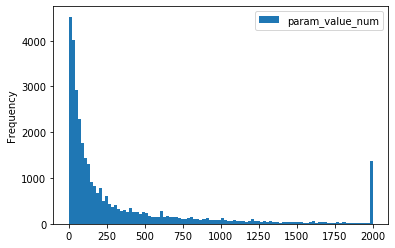

In [388]:
dftotals.clip(0, 2000).plot.hist(bins=100)

In [392]:
for i in range(0, 31):
    sub_df = dftotals[dftotals['param_value_num'] <= i]
    print(i, sub_df.shape[0], sub_df.shape[0]/dftotals.shape[0])

0 55 0.0016626360338573155
1 269 0.00813180169286578
2 526 0.015900846432889963
3 696 0.021039903264812577
4 967 0.02923216444981862
5 1170 0.03536880290205562
6 1475 0.04458887545344619
7 1638 0.04951632406287787
8 1915 0.057889963724304716
9 2082 0.06293833131801693
10 2518 0.07611850060459492
11 2683 0.08110640870616687
12 3046 0.09207980652962515
13 3211 0.0970677146311971
14 3472 0.10495767835550181
15 3686 0.11142684401451028
16 3974 0.12013301088270859
17 4106 0.12412333736396615
18 4399 0.13298065296251513
19 4524 0.13675937122128173
20 5037 0.15226723095525999
21 5197 0.15710399032648126
22 5454 0.16487303506650544
23 5557 0.16798669891172915
24 5928 0.17920193470374848
25 6112 0.18476420798065296
26 6323 0.19114268440145102
27 6422 0.1941354292623942
28 6667 0.2015417170495768
29 6761 0.20438331318016928
30 7136 0.21571946795646915


### Decision: let's pick 30 as the total cut-off, which leave roughly 80% or 25k studies

In [411]:
df_totals_used = dftotals[dftotals['param_value_num'] >= 30]
df_totals_used.shape

(26319, 1)

## what are the studies that do not have atleast 2 non-zero-non-total groups?

In [418]:
# excluding studies with < 30 total participants
dfm_sub = dfm[dfm['nct_id'].isin(df_totals_used.index)]
dfm_sub.shape

(171076, 20)

In [419]:
df_nonzero = dfm_sub[dfm_sub['param_value_num'] > 0]
df_nonzero.shape

(167103, 20)

In [510]:
df_nonzero.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Control Group', 'Usual Care',
       'All Participants', 'Placebo Group', 'Intervention',
       'All Study Participants', 'Standard of Care', 'Entire Study Population',
       'Vehicle', 'Group 1', 'Treatment', 'Group 2', 'Overall Study',
       'Overall', 'Arm 1', 'Sugar Pill', 'Arm 2', 'Total Title',
       'Standard Care', 'Cohort 2', 'Cohort 1', 'Control Arm', 'Group B',
       'Pregabalin', 'Sitagliptin', 'Group A', 'All Subjects', 'Varenicline',
       'Normal Saline', 'Intervention Group', 'Arm I', 'Duloxetine',
       'Etanercept', 'Sham', 'Saline', 'Metformin', 'Treatment as Usual',
       'Active', 'Arm A', 'Cohort 3', 'Experimental', 'Group 3', 'Arm B',
       'Pioglitazone', 'Placebo Arm', 'Escitalopram', 'Adalimumab'],
      dtype='object', name='title_rg')

In [511]:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [514]:
df_nonzero_non_total = df_nonzero[~df_nonzero['title_rg'].isin(total_strings)]

In [516]:
df_nonzero_groups = df_nonzero_non_total.groupby(['nct_id'])['ctgov_group_code'].nunique()
df_nonzero_groups.shape

(25849,)

In [517]:
df_nonzero_used = df_nonzero_groups[df_nonzero_groups > 1].index
len(df_nonzero_used)

21239

In [518]:
# excluding studies with less than 1 group where there is a non-zero number
dfm_used = dfm_sub[dfm_sub['nct_id'].isin(df_nonzero_used)]

In [519]:
num_final = dfm_used.groupby('nct_id').sum().shape[0] 
num_final / bm_all, num_final

(0.556023875595581, 21239)

at the end, we are left with 56% of our studies (21k)

### rerunning code from before to get the largest groups

In [549]:
dfm_used_no_pct = dfm_used[dfm_used['units'].apply(lambda x: False if 'percent' in x.lower() else True)]

In [550]:
dfm_grptot = dfm_used_no_pct.groupby(['nct_id', 'ctgov_group_code'])[['param_value_num']].sum().reset_index()
dfm_grptot

,nct_id,ctgov_group_code,param_value_num
0,NCT00000125,B1,819.0
1,NCT00000125,B2,817.0
2,NCT00000125,B3,1636.0
3,NCT00000134,B1,89.0
4,NCT00000134,B2,94.0
...,...,...,...
80127,NCT04137627,B3,25.0
80128,NCT04144088,B1,20.0
80129,NCT04144088,B2,20.0
80130,NCT04144088,B3,20.0


In [551]:
idx = dfm_grptot.groupby(['nct_id'], sort=False)['param_value_num'].transform(max) == dfm_grptot['param_value_num']
dfm_max_rows = dfm_grptot[idx]

In [552]:
dfm_maxgrp_titles = dfm_max_rows.merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']],
                                       on=['nct_id', 'ctgov_group_code'],
                                       how='inner').set_index('nct_id')

In [553]:
dfm_maxgrp_titles.groupby('title').size().sort_values(ascending=False)

title
Total                                                        21150
Total Title                                                     62
TOTAL                                                           15
IDeg                                                             1
10PP-HD 3+0d Group                                               1
10PP-LD 3+0d Group                                               1
Clinically Driven Monitoring (CDM)                               1
Continuous Glucose Monitoring                                    1
Electronically-Measuring Adherence Intervention: Patients        1
GSK134612A Form1 (C), Primary Group                              1
MenACWY (6-10 Years Old)                                         1
MenACWY-PS (6-10 Years Old)                                      1
Part 2: Placebo Cohort 1-4                                       1
Pooled AF37702 Inj.                                              1
Prevnar13 3+0d Group                                    

In [554]:
dfm_maxgrp_titles[dfm_maxgrp_titles['title'] == 'IDeg']

,ctgov_group_code,param_value_num,title
nct_id,,,
NCT01388361,B1,236.0,IDeg


In [555]:
dfm[dfm['nct_id'] == 'NCT01388361']

,nct_id,result_group_id,id,ctgov_group_code,classification,category,title,description,units,param_type,param_value,param_value_num,dispersion_type,dispersion_value,dispersion_value_num,dispersion_lower_limit,dispersion_upper_limit,explanation_of_na,is_male,title_rg
107686,NCT01388361,2525098,2794247,B4,,Male,"Sex: Female, Male",Randomised population.,Participants,Count of Participants,NA,NaN,,None,NaN,NaN,NaN,Total not calculated because data are not avai...,True,Total
107687,NCT01388361,2525098,2794251,B4,,Female,"Sex: Female, Male",Randomised population.,Participants,Count of Participants,NA,NaN,,None,NaN,NaN,NaN,Total not calculated because data are not avai...,False,Total
107688,NCT01388361,2525098,2794255,B4,,Male,"Sex: Female, Male",Non-randomised population.,Participants,Count of Participants,NA,NaN,,None,NaN,NaN,NaN,Total not calculated because data are not avai...,True,Total
107689,NCT01388361,2525098,2794259,B4,,Female,"Sex: Female, Male",Non-randomised population.,Participants,Count of Participants,NA,NaN,,None,NaN,NaN,NaN,Total not calculated because data are not avai...,False,Total
107690,NCT01388361,2525099,2794248,B3,,Male,"Sex: Female, Male",Randomised population.,Participants,Count of Participants,53,53.0,,None,NaN,NaN,NaN,,True,IDeg + IAsp OD
107691,NCT01388361,2525099,2794252,B3,,Female,"Sex: Female, Male",Randomised population.,Participants,Count of Participants,36,36.0,,None,NaN,NaN,NaN,,False,IDeg + IAsp OD
107692,NCT01388361,2525099,2794256,B3,,Male,"Sex: Female, Male",Non-randomised population.,Participants,Count of Participants,NA,NaN,,None,NaN,NaN,NaN,"Values available in the next row, baseline val...",True,IDeg + IAsp OD
107693,NCT01388361,2525099,2794260,B3,,Female,"Sex: Female, Male",Non-randomised population.,Participants,Count of Participants,NA,NaN,,None,NaN,NaN,NaN,"Values available in the next row, baseline val...",False,IDeg + IAsp OD
107694,NCT01388361,2525100,2794249,B2,,Male,"Sex: Female, Male",Randomised population.,Participants,Count of Participants,63,63.0,,None,NaN,NaN,NaN,,True,IDeg + Liraglutide
107695,NCT01388361,2525100,2794253,B2,,Female,"Sex: Female, Male",Randomised population.,Participants,Count of Participants,25,25.0,,None,NaN,NaN,NaN,,False,IDeg + Liraglutide


In [530]:
dfm['units'].unique()

array(['participants', 'Participants', 'participants in follow up study',
       'percent', 'Patients', 'Number', 'Subjects', 'Participant',
       'participant', 'hips', 'infants', 'percentage of participants',
       'subjects', 'partipants', 'participants with data available',
       'Paricipants', 'eyes', 'male/female', 'Percentage of participants',
       'blood samples', 'Count of participants', 'patients'], dtype=object)